Company XYZ is an e-commerce site that sells hand-made clothes.

You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.

You only have information about the user ** ﬁrst transaction ** on the site and based on that you have to make your classiﬁcation ("fraud/no fraud").

# Index
* [Answer question 1](#Answer-question-1)
* [Answer question 2](#Answer-question-2)
    * [Feature Engineering](#Feature-Engineering)
    * [Train the model](#Train-the-model)
    * [Plot ROC and choose threshold](#Plot-ROC-and-choose-threshold)
    * [Impact of FP vs. FN](#Impact-of-FP-vs.-FN)
* [Answer question 3](#Answer-question-3)
* [Answer question 4](#Answer-question-4)

In [2]:
import bisect
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score,classification_report,roc_curve
import xgboost as xgb

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Answer question 1
<span style='color:blue'>For each user, determine her country based on the numeric IP address.</span>

I will use ** Binary Search ** to map IP address to country.

In [9]:
class IpLookupTable(object):
    def __init__(self, df):
        """
        input: 
            df: DataFrame read from 'IpAddress_to_Country.csv'
        """
        self._nrows = df.shape[0]
        # add two more slots, one is for the ipaddress < minimum ipaddress from the file
        # another is for the ipaddress > maximum ipaddress from the file
        self._ip_lowbounds = [0 for _ in range(self._nrows + 2)]
        self._countries = ["Unknown" for _ in range(self._nrows + 2)]

        # start from 1, because 0-th cell is for ipaddress < minimal known ipaddress
        for r in range(1, self._nrows + 1):
            self._ip_lowbounds[r] = df.iloc[r - 1, 0]
            self._countries[r] = df.iloc[r - 1, 2]
            # assume the file is in ascending order
            assert self._ip_lowbounds[r] > self._ip_lowbounds[r - 1]

        # we cannot assign all ip> last low boundary to be that country
        # so I create a dummy ipaddress which larger than maximal known ipaddress
        self._ip_lowbounds[self._nrows + 1] = df.iloc[self._nrows - 1, 1] + 1

    def find_country(self, ip):
        index = bisect.bisect(self._ip_lowbounds, ip) - 1
        # within the range, or in last cell which doesn't have next cell
        assert ip >= self._ip_lowbounds[index] and (index == self._nrows + 1 or ip < self._ip_lowbounds[index + 1])
        return self._countries[index]

In [10]:
ip2country = pd.read_csv("IpAddress_to_Country.csv")
iplookuptable = IpLookupTable(ip2country)

In [20]:
ip2country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [16]:
datas = pd.read_csv("Fraud_Data.csv",index_col='user_id')

In [17]:
datas["country"] = datas.ip_address.map(iplookuptable.find_country)

In [6]:
datas.country.value_counts()

United States                      59222
Unknown                            20017
China                              12038
Japan                               7918
United Kingdom                      4492
Korea Republic of                   4162
Germany                             3647
France                              3163
Canada                              2981
Brazil                              2961
Italy                               1946
Australia                           1845
Netherlands                         1825
Russian Federation                  1616
India                               1310
Taiwan; Republic of China (ROC)     1237
Mexico                              1121
Sweden                              1090
Spain                               1027
South Africa                         838
Switzerland                          785
Poland                               729
Argentina                            661
Indonesia                            649
Norway          

In [21]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 22058 to 138208
Data columns (total 11 columns):
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           151112 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 13.8+ MB


we can see some visits are from very <span style='color:red;font-size:1.5em;font-weight:bold'>rare countries</span>.

In [22]:
minip = ip2country.iloc[0,0]
maxip = ip2country.iloc[-1,1]

# check all IP from 'Unknown' country are either < minip or > maxip
country_unknown_ips = datas.loc[datas.country == 'Unknown','ip_address']
smaller_than_min = country_unknown_ips < minip
larger_than_max = country_unknown_ips > maxip
assert (np.all( smaller_than_min | larger_than_max))# check succeeds

# Answer question 2
<span style='color:blue'>Build a model to predict whether an activity is fraudulent or not. Explain how diﬀerent assumptions about the cost of false positives vs false negatives would impact the model.</span>

## Feature Engineering

In [23]:
datas['signup_time'] = pd.to_datetime(datas.signup_time)
datas['purchase_time'] = pd.to_datetime(datas.purchase_time)

# it is very suspicious for a user signup and then immediately purchase
datas['interval_after_signup'] = (datas.purchase_time - datas.signup_time).dt.total_seconds()

datas.drop(["signup_time", "purchase_time"], axis=1, inplace=True)

In [24]:
# how many times a device is shared
n_dev_shared = datas.device_id.value_counts()

# because we are studying user's first transaction
# the more a device is shared, the more suspicious
datas['n_dev_shared'] = datas.device_id.map(n_dev_shared)
del datas['device_id']

In [25]:
# how many times a ip address is shared
n_ip_shared = datas.ip_address.value_counts()

# because we are studying user's first transaction
# the more a ip is shared, the more suspicous
datas['n_ip_shared'] = datas.ip_address.map(n_ip_shared)
del datas['ip_address']

In [26]:
# how many users are from the same country
n_country_shared = datas.country.value_counts()

# the less visit from a country, the more suspicious
datas['n_country_shared'] = datas.country.map(n_country_shared)
del datas['country']

In [27]:
datas.head()#glance

,purchase_value,source,browser,sex,age,class,interval_after_signup,n_dev_shared,n_ip_shared,n_country_shared
user_id,,,,,,,,,,
22058,34,SEO,Chrome,M,39,0,4506682.0,1,1,7918
333320,16,Ads,Chrome,F,53,0,17944.0,1,1,59222
1359,15,SEO,Opera,M,53,1,1.0,12,12,59222
150084,44,SEO,Safari,M,41,0,492085.0,1,1,20017
221365,39,Ads,Safari,M,45,0,4361461.0,1,1,59222


In [28]:
datas['is_male'] = (datas.sex == 'M').astype(int)
del datas['sex']

In [29]:
datas.source.value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

In [30]:
datas.browser.value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

In [31]:
datas = pd.get_dummies(datas,columns=['source','browser'])

del datas['source_Direct']
del datas['browser_Opera']
datas.head()

,purchase_value,age,class,interval_after_signup,n_dev_shared,n_ip_shared,n_country_shared,is_male,source_Ads,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Safari
user_id,,,,,,,,,,,,,,
22058,34,39,0,4506682.0,1,1,7918,1,0,1,1,0,0,0
333320,16,53,0,17944.0,1,1,59222,0,1,0,1,0,0,0
1359,15,53,1,1.0,12,12,59222,1,0,1,0,0,0,0
150084,44,41,0,492085.0,1,1,20017,1,0,1,0,0,0,1
221365,39,45,0,4361461.0,1,1,59222,1,1,0,0,0,0,1


In [33]:
datas.rename(columns={'class':'is_fraud'},inplace=True)# 'class' is a reserved keyword

In [35]:
datas.head()

,purchase_value,age,is_fraud,interval_after_signup,n_dev_shared,n_ip_shared,n_country_shared,is_male,source_Ads,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Safari
user_id,,,,,,,,,,,,,,
22058,34,39,0,4506682.0,1,1,7918,1,0,1,1,0,0,0
333320,16,53,0,17944.0,1,1,59222,0,1,0,1,0,0,0
1359,15,53,1,1.0,12,12,59222,1,0,1,0,0,0,0
150084,44,41,0,492085.0,1,1,20017,1,0,1,0,0,0,1
221365,39,45,0,4361461.0,1,1,59222,1,1,0,0,0,0,1


In [36]:
datas.to_csv("fraud_cleaned.csv",index="user_id")

## Train the model

In [37]:
seed = 999
X = datas.loc[:,datas.columns != 'is_fraud']
y = datas.is_fraud

# split into training dataset and test dataset
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=seed)
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

use cross-validation to find best number of trees

In [38]:
params = {}
params['silent'] = 1
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[0]	train-auc:0.843692+0.000887623	test-auc:0.843268+0.00380566
[1]	train-auc:0.843812+0.00101273	test-auc:0.843448+0.0037979
[2]	train-auc:0.845079+0.00203092	test-auc:0.84399+0.00450984
[3]	train-auc:0.84528+0.00207382	test-auc:0.844128+0.00442481
[4]	train-auc:0.846021+0.00227639	test-auc:0.844037+0.00455659
[5]	train-auc:0.846081+0.00226199	test-auc:0.844056+0.00463579
[6]	train-auc:0.84656+0.00280405	test-auc:0.843645+0.00387232
[7]	train-auc:0.84733+0.00332963	test-auc:0.842942+0.00444148
[8]	train-auc:0.848612+0.00379694	test-auc:0.843972+0.00352551
[9]	train-auc:0.849742+0.00307915	test-auc:0.844721+0.00417795
[10]	train-auc:0.85093+0.00341914	test-auc:0.845214+0.00330733
[11]	train-auc:0.851951+0.00405486	test-auc:0.84536+0.00342724
[12]	train-auc:0.85429+0.00320063	test-auc:0.845332+0.00376944
[13]	train-auc:0.856341+0.00306496	test-auc:0.845524+0.00405848
[14]	train-auc:0.857493+0.00206642	test-auc:0.844576+0.00415615
[15]	train-auc:0.859244+0.00159173	test-auc:0.844726+0.00

In [39]:
cv_results

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.843268,0.003806,0.843692,0.000888
1,0.843448,0.003798,0.843812,0.001013
2,0.843990,0.004510,0.845079,0.002031
3,0.844128,0.004425,0.845280,0.002074
4,0.844037,0.004557,0.846021,0.002276
5,0.844056,0.004636,0.846081,0.002262
6,0.843645,0.003872,0.846560,0.002804
7,0.842942,0.004441,0.847330,0.003330
8,0.843972,0.003526,0.848612,0.003797
9,0.844721,0.004178,0.849742,0.003079


In [40]:
n_best_trees = cv_results.shape[0]
n_best_trees

38

In [41]:
# retrain on the whole training dataset
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[0]	train-auc:0.841606
[1]	train-auc:0.843293
[2]	train-auc:0.843408
[3]	train-auc:0.846209
[4]	train-auc:0.846266
[5]	train-auc:0.846326
[6]	train-auc:0.846395
[7]	train-auc:0.84641
[8]	train-auc:0.846641
[9]	train-auc:0.848747
[10]	train-auc:0.849681
[11]	train-auc:0.851053
[12]	train-auc:0.850995
[13]	train-auc:0.853027
[14]	train-auc:0.855058
[15]	train-auc:0.857772
[16]	train-auc:0.85964
[17]	train-auc:0.860389
[18]	train-auc:0.861063
[19]	train-auc:0.862866
[20]	train-auc:0.86353
[21]	train-auc:0.864557
[22]	train-auc:0.864495
[23]	train-auc:0.866279
[24]	train-auc:0.867187
[25]	train-auc:0.868545
[26]	train-auc:0.869555
[27]	train-auc:0.869594
[28]	train-auc:0.870787
[29]	train-auc:0.871613
[30]	train-auc:0.873818
[31]	train-auc:0.875035
[32]	train-auc:0.876535
[33]	train-auc:0.87786
[34]	train-auc:0.878565
[35]	train-auc:0.878659
[36]	train-auc:0.878788
[37]	train-auc:0.879652


## Plot ROC and choose threshold

In [42]:
def plot_validation_roc():
    """
    we cannot plot ROC on either training set or test set, since both are biased
    so I split the training dataset again into training set and validation set
    retrain on training set and plot ROC on validation set and choose a proper cutoff value
    
    define a class to limit the naming group, avoid polluting the global naming space
    """
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.3,random_state=seed)
    onlytrain_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid,yvalid)

    temp_gbt = xgb.train(params, onlytrain_matrix, n_best_trees,[(onlytrain_matrix,'train_only'),(valid_matrix,'validate')])
    yvalid_proba_pred = temp_gbt.predict(valid_matrix,ntree_limit=n_best_trees)

    fpr,tpr,thresholds = roc_curve(yvalid,yvalid_proba_pred)
    return pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':thresholds})

In [43]:
roc = plot_validation_roc()

[0]	train_only-auc:0.769891	validate-auc:0.771598
[1]	train_only-auc:0.843895	validate-auc:0.844289
[2]	train_only-auc:0.843944	validate-auc:0.844283
[3]	train_only-auc:0.843944	validate-auc:0.844283
[4]	train_only-auc:0.843986	validate-auc:0.844335
[5]	train_only-auc:0.844019	validate-auc:0.844334
[6]	train_only-auc:0.844119	validate-auc:0.844307
[7]	train_only-auc:0.844181	validate-auc:0.844279
[8]	train_only-auc:0.844278	validate-auc:0.844257
[9]	train_only-auc:0.844297	validate-auc:0.844224
[10]	train_only-auc:0.848505	validate-auc:0.845313
[11]	train_only-auc:0.855143	validate-auc:0.845924
[12]	train_only-auc:0.856127	validate-auc:0.846355
[13]	train_only-auc:0.858533	validate-auc:0.846989
[14]	train_only-auc:0.860583	validate-auc:0.847035
[15]	train_only-auc:0.863336	validate-auc:0.849067
[16]	train_only-auc:0.863318	validate-auc:0.84916
[17]	train_only-auc:0.866296	validate-auc:0.850081
[18]	train_only-auc:0.867346	validate-auc:0.849906
[19]	train_only-auc:0.869105	validate-auc:

Text(0, 0.5, 'TPR')

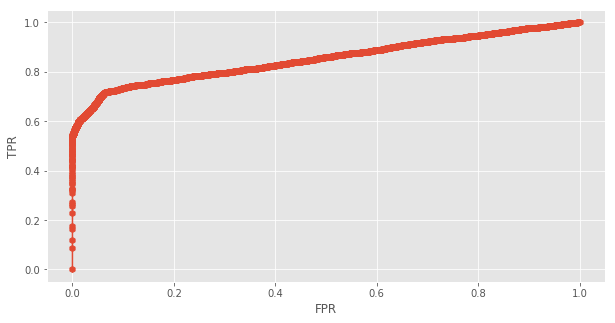

In [44]:
plt.figure(figsize=(10,5))
plt.plot(roc.FPR,roc.TPR,marker='h')
plt.xlabel("FPR")
plt.ylabel("TPR")

## Impact of FP vs. FN
* if ** false positive ** cost much higher, we should increase the probability threshold, but pay the price TPR is also decreased.
* if ** false negative ** cost much higher, we should decrease the probability threshold, but pay the price FPR is also increased.

In [45]:
roc.loc[ (roc.TPR >= 0.78) & (roc.TPR <=0.83),:]

,FPR,TPR,Threshold
1811,0.236571,0.780343,0.044153
1812,0.236952,0.780343,0.044149
1813,0.237437,0.780693,0.044148
1814,0.237506,0.780693,0.044147
1815,0.237541,0.780693,0.044146
1816,0.237680,0.780693,0.044146
1817,0.237818,0.780693,0.044142
1818,0.237818,0.781042,0.044141
1819,0.237922,0.781042,0.044138
1820,0.237991,0.781042,0.044138


in this case, because normally this "Fraud Detection Model" is often used in a pre-screening step, whose result will be further investigated by expert, so
* if 'Not Fraud' is classified as 'Fraud', human expert can still have method to fix the problem
* but if 'Fraud' is classified as 'Not Fraud', the company will lose money directly.

<span style='color:orange;font-size:1.5em;font-weight:bold'>so in this case, "false negative" cost much higher, so we should choose a relatively smaller threshold.</span>

# Answer question 3
<span style='color:blue'>Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classiﬁed as at risk? What are their characteristics?</span>

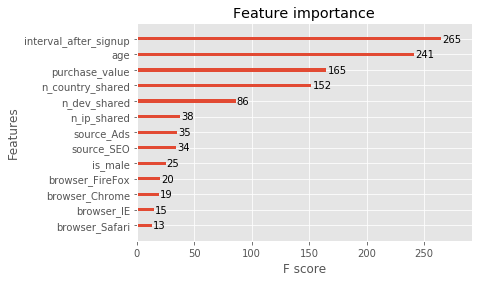

In [46]:
# first we plot the feature importance from GBM
xgb.plot_importance(gbt)

from above model, we can see that, ** 'interval_after_signup' ** is the most important factor helping us to decide a transaction is fraud or not.

To better understand, we fit a shallow, simple Decision Tree and plot it.

In [47]:
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)
export_graphviz(dt,feature_names=X.columns,class_names=['NotFraud','Fraud'],
                proportion=True,leaves_parallel=True,filled=True)

'digraph Tree {\nnode [shape=box, style="filled", color="black"] ;\ngraph [ranksep=equally, splines=polyline] ;\n0 [label="interval_after_signup <= 69.0\\ngini = 0.17\\nsamples = 100.0%\\nvalue = [0.906, 0.094]\\nclass = NotFraud", fillcolor="#e58139e5"] ;\n1 [label="gini = 0.0\\nsamples = 5.0%\\nvalue = [0.0, 1.0]\\nclass = Fraud", fillcolor="#399de5ff"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="n_dev_shared <= 1.5\\ngini = 0.087\\nsamples = 95.0%\\nvalue = [0.954, 0.046]\\nclass = NotFraud", fillcolor="#e58139f3"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n3 [label="interval_after_signup <= 8770937.0\\ngini = 0.059\\nsamples = 87.2%\\nvalue = [0.97, 0.03]\\nclass = NotFraud", fillcolor="#e58139f7"] ;\n2 -> 3 ;\n4 [label="gini = 0.058\\nsamples = 73.7%\\nvalue = [0.97, 0.03]\\nclass = NotFraud", fillcolor="#e58139f7"] ;\n3 -> 4 ;\n5 [label="gini = 0.065\\nsamples = 13.5%\\nvalue = [0.966, 0.034]\\nclass = NotFraud", fillcolor=

<img src='tree.png'></img>

from above plot, we focus on two leaf-nodes
* the blue leaf node indicates, <span style='color:red'>if 'interval_after_signup' is <=69 seconds, which means the customer purchases immediatelly after signup, then there is very high probability that this transaction is fraud</span>.
* the leaf-node with positive ratio=23% (the second node from right), if the purchase is <span style='color:red'>from a device shared by 2~4 users, then there is above-normal probability that the transaction is fraud.</span>

# Answer question 4
<span style='color:blue'>Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of diﬀerent user experiences would you build based on the model output?</span>

since my model can predict the probability a purchase is fraud, so I need to set two probability cutoffs as 'alert value', ** alert1 and alert2, and alert1 < alert2 **.

for a incoming purchase, my model will return the probability 'p' that the purchase is fraud,
* if p < alert1, then I assume the purchase is normal, proceed without any problem
* if alert1 <= p < alert2, then I assume the purchase is suspicious, I will ask the customer for additional authroization. for example, send email or SMS to the customer, let him/her authorize the purchase.
* if p>= alert2, then the purchase is highly suspicious, I not only ask the customer for additional authorization via email or SMS, but also put the purchase on hold and send the purchase information to some human expert for further investigation.